## load libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys, shutil
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import random

In [3]:
sys.path.insert(0, "../")
from utils.DLutils import *
from utils.vizutils import plot_col_dists
from create_toybrains import ToyBrainsData
from experiments.fit_DL_model import *

/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DEEPREPVIZ_REPO = "../../Deep-confound-control-v2/"
sys.path.append(DEEPREPVIZ_REPO)
from DeepRepViz import *

In [5]:
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger, WandbLogger

In [6]:
import logging
# disable some unneccesary lightning warnings
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

In [ ]:
DATASETS = ["../dataset/toybrains_n10000_highsignal",
            "../dataset/toybrains_n10000_midsignal",
            "../dataset/toybrains_n10000_lowsignal"]

## Generate toybrain datasets 
```bash
$ nohup python3 create_toybrains.py -c configs.lbl1cov1 -n 10000 --suffix n_highsignal &> nohup1.out &
$ nohup python3 create_toybrains.py -c configs.lbl1cov1_midsignal -n 10000 --suffix n_midsignal &>  nohup2.out &
$ nohup python3 create_toybrains.py -c configs.lbl1cov1_lowsignal -n 10000 --suffix n_lowsignal &> nohup3.out &
```

### Generative attr. dist.

In [9]:
# for data_dir in DATASETS:
#     data_name = data_dir.split('/')[-1]
#     df = pd.read_csv(f'{data_dir}/{data_name}.csv')
#     cov_cols = df.filter(regex='^(cov_|lbl_)').columns
#     attr_cols = df.filter(regex='^(?!(cov_|lbl_)).+').columns
#     plot_col_dists(df, 
#                    attr_cols=attr_cols, cov_cols=cov_cols, 
#                    title=f"{data_name}: Dist. of generative data attributes vs the labels")
#     plt.show()

### Baseline attr. accuracies

In [10]:
results = []
for data_dir in DATASETS:
    toy = ToyBrainsData("configs.lbl1cov1")
    # load the already generated dataset
    toy.load_generated_dataset(data_dir)
    result = toy.fit_baseline_models(CV=10) 
    results.append(result)

running a total of 70 different settings of [input] x [output] x [CV] and saving result in ../dataset/toybrains_n10000_highsignal


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 10.15it/s]


TOTAL RUNTIME: 0:00:08
running a total of 70 different settings of [input] x [output] x [CV] and saving result in ../dataset/toybrains_n10000_midsignal


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:04<00:00, 16.24it/s]


TOTAL RUNTIME: 0:00:05
running a total of 70 different settings of [input] x [output] x [CV] and saving result in ../dataset/toybrains_n10000_lowsignal


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:04<00:00, 16.59it/s]


TOTAL RUNTIME: 0:00:06


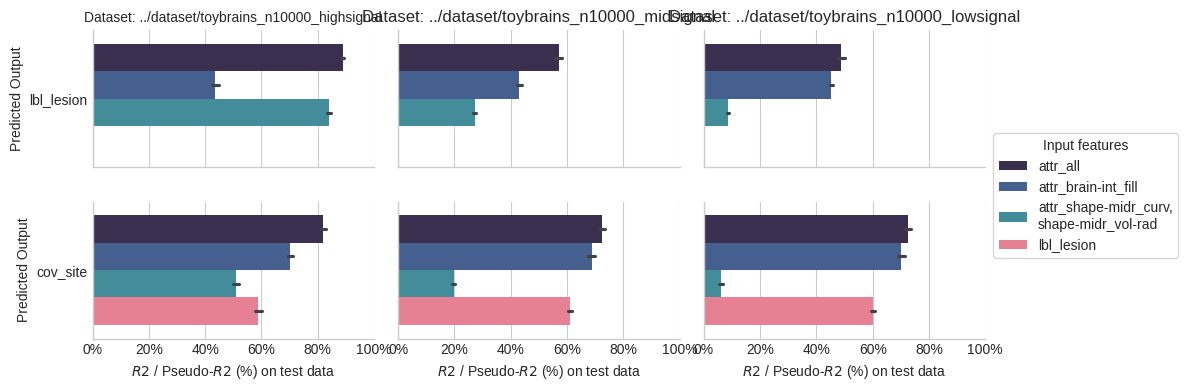

In [11]:
toy.viz_baseline_results(results)

#### collect the results in a df

In [36]:
df_baseline = pd.concat(results)

In [37]:
grp_by_cols = ['dataset', 'inp']
signal_col = 'test_metric'
df_baseline_temp = df_baseline.loc[df_baseline.out.apply(lambda x: 'lbl_' in x).values, grp_by_cols+[signal_col]]

In [38]:
df_baseline_temp = df_baseline_temp.groupby(grp_by_cols).mean().reset_index()
df_baseline_temp.inp = df_baseline_temp.inp.map({'attr_all':r'$BL_{total}$', 
                                                 'attr_shape-midr_curv, shape-midr_vol-rad':r'$BL_{signal}$',
                                                 'attr_brain-int_fill':r'$BL_{conf}$'})

In [39]:
df_final = {}
cols = []
for dataset, dfi in df_baseline_temp.groupby("dataset"):
    dfi = dfi[['inp','test_metric']].T
    dfi.columns = dfi.loc['inp'].values
    dfi = dfi.drop(index='inp')
    if not len(cols): 
        cols = dfi.columns
    vals = [dfi[c].values[0] for c in cols]
    df_final.update({dataset: vals})
    
df_final = pd.DataFrame.from_dict(df_final, orient='index', columns=cols)
df_final.index.name = 'Dataset'
df_final.index = df_final.index.str.replace('../dataset/toybrains_n10000_', '')
df_final.style.bar(vmin=0, vmax=1)

,$BL_{total}$,$BL_{conf}$,$BL_{signal}$
Dataset,,,
highsignal,0.888686,0.436292,0.841490
lowsignal,0.486721,0.452580,0.086718
midsignal,0.570342,0.430726,0.271618


## Fit DL models

In [8]:
debug = True
label = "lbl_lesion"
random_seed=42 if debug else None
batch_size=64

#### select the GPU

In [9]:
# check GPUs available and memory
! gpustat

cuda01                         Wed Nov  8 16:53:21 2023  545.23.06
[0] NVIDIA GeForce GTX 1080 Ti | 26'C,   0 % |    98 / 11264 MB | gdm(4M)
[1] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |    98 / 11264 MB | gdm(4M)
[2] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |    98 / 11264 MB | gdm(4M)
[3] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |    98 / 11264 MB | gdm(4M)
[4] NVIDIA GeForce GTX 1080 Ti | 26'C,   0 % |    98 / 11264 MB | gdm(4M)
[5] NVIDIA GeForce GTX 1080 Ti | 26'C,   0 % |    98 / 11264 MB | gdm(4M)
[6] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |    98 / 11264 MB | gdm(4M)
[7] NVIDIA GeForce GTX 1080 Ti | 26'C,   0 % |    98 / 11264 MB | gdm(4M)


In [10]:
GPUs = [1]

In [11]:
torch.set_float32_matmul_precision('medium')
os.environ["CUDA_LAUNCH_BLOCKING"]="1"
os.environ["TF_ENABLE_ONEDNN_OPTS"]="0"

#### Model config

In [12]:
model_class = SimpleCNN
model_kwargs=dict(num_classes=1, final_act_size=32)

test model init and see model layer names for hook

In [13]:
model = model_class(**model_kwargs)

In [14]:
get_all_model_layers(model)

[('0', Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('0', Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('0', Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('1', Linear(in_features=4096, out_features=32, bias=True)),
 ('2', Linear(in_features=32, out_features=1, bias=True))]

#### Load data

In [15]:
dataset_path = DATASETS[0]
unique_name = dataset_path.split('/')[-1].split('_')[-1]
raw_csv_path = glob(f'{dataset_path}/*{unique_name}.csv')[0]
df_data = pd.read_csv(raw_csv_path)

In [16]:
# split the dataset
df_train, df_val, df_test = split_dataset(df_data, label, random_seed)

print(f"Dataset: {dataset_path} ({unique_name})\n  Training data split = {len(df_train)} \n \
 Validation data split = {len(df_val)} \n  Test data split = {len(df_test)}")

# generate data loaders
common_settings = dict(images_dir=dataset_path+'/images',
                       batch_size=batch_size,
                       num_workers=16)

train_loader = get_toybrain_dataloader(
                df_train,
                **common_settings)
val_loader = get_toybrain_dataloader(
                df_val, shuffle=False,
                **common_settings)
test_loader = get_toybrain_dataloader(
                df_test, shuffle=False,
                **common_settings)

Dataset: ../dataset/toybrains_n10000_highsignal (highsignal)
  Training data split = 7809 
  Validation data split = 191 
  Test data split = 2000


#### DeepRepViz Init

In [26]:
# create one full dataloader with the whole data and no shuffle enabled
split_colname = 'datasplit'
ID_col = 'subjectID'
# add the split info too
df_train[split_colname] = 'train'
df_val[split_colname]   = 'val'
df_test[split_colname]  = 'test'
df_data = pd.concat([df_train, df_val, df_test])
IDs = df_data[ID_col].values
expected_labels = df_data[label].values
datasplits = df_data[split_colname].values

drv_loader_kwargs = dict(
                img_dir=dataset_path+'/images',
                img_names=df_data[ID_col].values,
                labels=df_data[label].values,
                transform=transforms.ToTensor())

deeprepviz_kwargs = dict(
                 dataloader_class=ToyBrainsDataloader, 
                 dataloader_kwargs=drv_loader_kwargs,
                 expected_IDs=IDs, expected_labels=expected_labels, datasplits=datasplits,
                 hook_layer=-1,
                 debug=False)

In [28]:
# test DeepRepViz config
DeepRepViz(**deeprepviz_kwargs)

#### run training 

In [30]:
# setup training args
logger_args = dict(save_dir='log', 
                   name=f'toybrains-{unique_name}')
trainer_args = {"max_epochs":5 if debug else 50, 
                "accelerator":'gpu',
                "devices":[1]}
early_stop_patience  = 6

# reinit model
model = model_class(**model_kwargs)

# reinit deeprepviz
drv = DeepRepViz(**deeprepviz_kwargs)

callbacks=[drv]
if early_stop_patience:
    callbacks.append(EarlyStopping(monitor="val_loss", mode="min", 
                                   patience=early_stop_patience))
    
lightning_model = LightningModel(model, learning_rate=0.05, 
                                 num_classes=model_kwargs['num_classes'])
# configure trainer settings
logger = TensorBoardLogger( **logger_args)

# delete previous logs
# try:
#     # shutil.rmtree('deeprepvizlog/')
#     shutil.rmtree('log/')
#     # shutil.rmtree('checkpoints/')
#     # if os.path.isdir(logger.log_dir): 
#     #     shutil.rmtree(logger.log_dir+'/')
#     # else:
# except:
#     pass

# train model
trainer = L.Trainer(callbacks=callbacks,
                    logger=logger,
                    overfit_batches= 5 if debug else 0,
                    log_every_n_steps= 2 if debug else 50,
                    **trainer_args) # deterministic=True
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader)


# test model
test_scores = trainer.test(lightning_model, verbose=False,
                           dataloaders=test_loader,
                          )[0]

print("Test data performance with the best model:\n\
-------------------------------------------------------\n\
Dataset      = {} ({})\n\
Balanced Acc = {:.2f}% \t D2 = {:.2f}%".format(
    dataset_path, unique_name, 
     test_scores['test_BAC']*100,  test_scores['test_D2']*100))


  | Name           | Type              | Params
-----------------------------------------------------
0 | model          | SimpleCNN         | 154 K 
1 | _metric_spec   | BinarySpecificity | 0     
2 | _metric_recall | BinaryRecall      | 0     
3 | metric_D2      | D2metric          | 0     
-----------------------------------------------------
154 K     Trainable params
0         Non-trainable params
154 K     Total params
0.620     Total estimated model params size (MB)


/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:268: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.96it/s, v_num=1]
Validation: |                                                                                                                              | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████| 5/5 [00:00<00:00,  5.80it/s, v_num=1, val_loss=42.00, val_BAC=0.500, val_D2=-11.3, train_loss=44.90, train_BAC=0.500, train_D2=-8.26]
Validation: |                                                                                                                              | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████| 5/5 [00:01<00:00,  4.93it/s, v_num=1, val_loss=144.0, val_BAC=0.500, val_D2=-11.3, train_loss=3.420, train_BAC=0.557, train_D2=-3.61]
Validation: |                                                                                                                              | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|████████████| 

## Process DeepRepVizLogs

In [119]:
from DeepRepVizBackend import DeepRepVizBackend
drv_backend = DeepRepVizBackend(
                  conf_table=df_data,
                  ID_col=ID_col, label_col=label, split_col=split_colname)


#### generate v1 table

In [26]:
df = drv.convert_log_to_v1_table(
    unique_name=f"{model_class.__name__}", #-TSNE3
    # dim_reduct_method=dim_reduct_method,
    # ckpts_dir="log/toybrains-n10000/version_0/deeprepvizlog",
)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


### load the features and metrics at the best checkpoint

In [121]:
drv_backend.load_log(logsdir='log/toybrains-highsignal_SimpleCNN_cls1-fea64/version_0/deeprepvizlog/')
# drv_backend.deeprepvizlogs

In [25]:
# dim_reduct_method = TSNE(n_components=3, learning_rate='auto',
#                          init='random', perplexity=3) 

In [27]:
# %reload_ext tensorboard
# %tensorboard --logdir=./log/lightning_logs/

In [28]:
# !kill -9 1237900